In [30]:
import pickle
import torch
import torch_geometric as tg

import networkx as nx

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

### Example Script

In [31]:
with open(r'inf_scores_gcn_with_adj.pkl', 'rb') as f:
    all_res = pickle.load(f)
    print(f"{len(all_res)} graphs loaded")

x = all_res[0]

32 graphs loaded


In [32]:
# Normalisation code

inf = x['influence_score'].copy()

def row_normalise(inf):

    row_totals = inf.sum(axis=1)
    norm = (inf.T/row_totals).T

    return norm

assert np.allclose(row_normalise(inf).sum(axis=1), 1.0)

In [33]:
inf = row_normalise(inf)
df = pd.DataFrame(inf)

In [34]:
df.index.name = 'source' # TODO is this right?

melted = df.melt(ignore_index = False)
melted = melted.reset_index() # Move source index to be a column, gives unique index
melted = melted.rename(columns={'variable': 'target',
                                'value': 'influence_score',
                                'index': 'source'})

In [35]:
source_coords = pd.DataFrame(x['xpos'])
target_coords = source_coords.copy()

source_coords.index.name = 'source'
source_coords = source_coords.reset_index()

target_coords.index.name = 'target'
target_coords = target_coords.reset_index()


target_cords = target_coords.rename(columns={0: 'target_x', 1: 'target_y'})
source_coords = source_coords.rename(columns={0: 'source_x', 1: 'source_y'})

In [36]:
print(len(melted))

238144


In [37]:
melted = melted.merge(source_coords, on='source', how='left')
melted = melted.merge(target_cords, on='target', how='left')

In [38]:
print(len(melted))

238144


In [39]:
melted['distance_sq'] = (melted['source_x'] - melted['target_x'])**2 + (melted['source_y'] -
                                                                        melted['target_y'] )**2
melted['distance'] = np.sqrt(melted['distance_sq'])

In [40]:
print(len(melted))

238144


<Axes: xlabel='distance', ylabel='influence_score'>

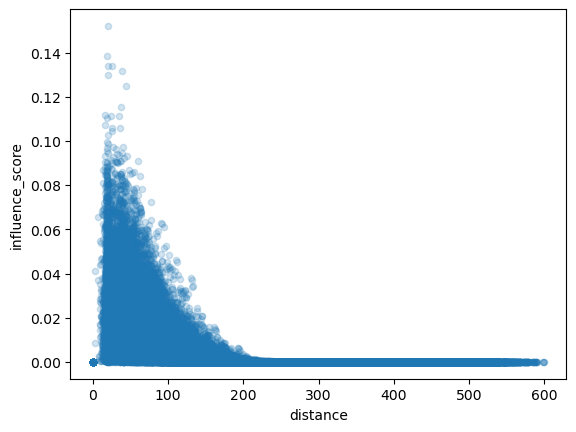

In [41]:
melted.plot.scatter('distance', 'influence_score', logy=False, alpha=0.2)

### Graph Based Distance Measure

In [42]:
edges = x['edges'].copy().astype(int)

coords = x['xpos'].copy()

edges = torch.Tensor(edges)
coords = torch.Tensor(coords)

data = tg.data.Data(edge_index=edges,
                    x=coords)

In [43]:
g = tg.utils.convert.to_networkx(data)

In [44]:
shortest_paths = nx.algorithms.shortest_paths.dense.floyd_warshall_numpy(g, weight=None)
shortest_paths = pd.DataFrame(shortest_paths)

shortest_paths_map = shortest_paths.melt(ignore_index=False)
shortest_paths_map = shortest_paths_map.reset_index()
shortest_paths_map = shortest_paths_map.rename(columns={'index': 'source',
                                                        'variable': 'target',
                                                        'value': 'graph_distance'}
                                               )

shortest_paths_map['graph_distance'] = shortest_paths_map['graph_distance'].astype('int')

<Axes: xlabel='graph_distance', ylabel='influence_score'>

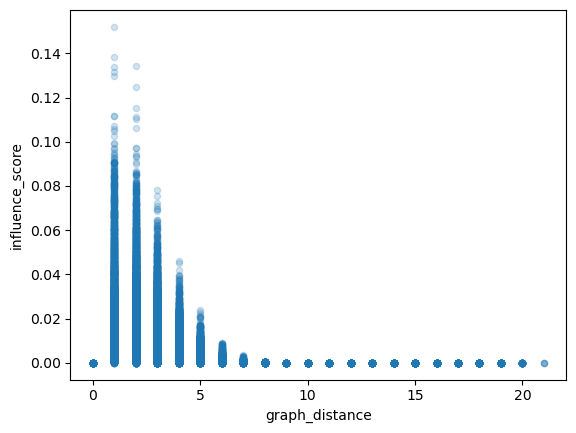

In [45]:
melted = melted.merge(shortest_paths_map, on=['source', 'target'])
melted.plot.scatter('graph_distance', 'influence_score', logy=False, alpha=0.2,)

<Axes: xlabel='graph_distance'>

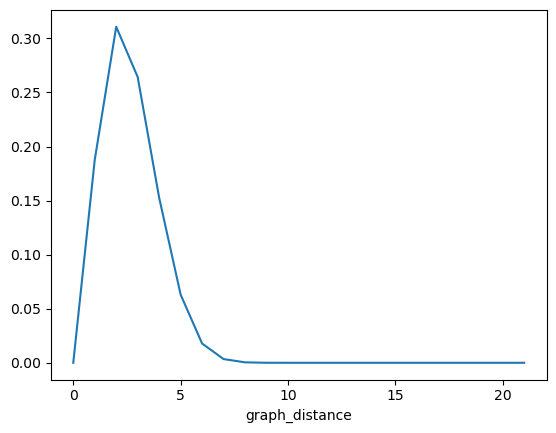

In [46]:
per_distance_per_source = melted.groupby(['graph_distance', 'source'])['influence_score'].sum()
per_distance_per_source.groupby('graph_distance').mean().plot()

In [47]:
per_distance_per_source.groupby('graph_distance').mean().sum()

1.0

### Proper pipeline

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
from influence import process_all_graphs, plot_mean_influence_by_distance

In [56]:
influence_df_gcn = process_all_graphs('inf_scores_gcn_with_adj.pkl',
                                      normalise=True)

32 graphs loaded


In [57]:
influence_df_transformer = process_all_graphs('inf_scores_GT_with_adj.pkl',
                                              normalise=True)

64 graphs loaded


In [58]:
influence_df_egnn = process_all_graphs('inf_scores_egnn.pkl', normalise=True)

64 graphs loaded


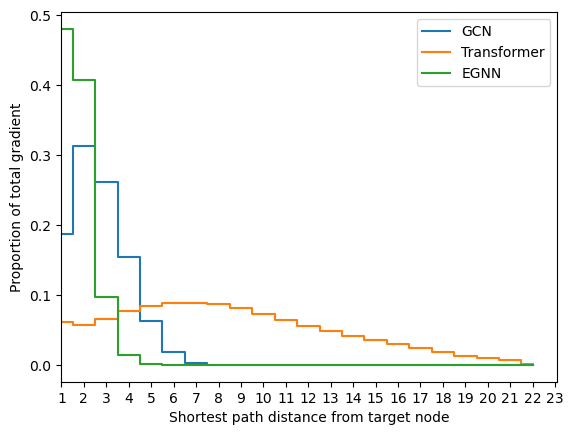

In [69]:
fig, ax = plt.subplots()
plot_mean_influence_by_distance(influence_df_gcn, ax, 'GCN')
plot_mean_influence_by_distance(influence_df_transformer, ax, 'Transformer')
plot_mean_influence_by_distance(influence_df_egnn, ax, 'EGNN')

# Stomp axis limits to remove boring 0 path length
xmin, xmax = ax.get_xlim()
ax.set_xlim(1, xmax)
ax.set_xticks(range(1, int(xmax)+1))

ax.set_xlabel('Shortest path distance from target node')
ax.set_ylabel('Proportion of total gradient')
ax.legend()